# Layered Network

##### Imports

In [21]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'modules')))
from hh_model import HodgkinHuxleyNeuron
from layered_network import LayeredNetworkGraph

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

### Directed Erdos-Renyi Graph

In [22]:
def generate_erdos_renyi_digraph(n, p, s=''):
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Add nodes with custom names
    names = [s + str(i) for i in range(n)]
    for name in names:
        G.add_node(name)  # Assuming HodgkinHuxleyNeuron() is defined elsewhere
    
    # Add edges based on Erdos-Renyi probability
    for i, u in enumerate(names):
        for j, v in enumerate(names):
            if i != j and random.random() < p:
                G.add_edge(u, v)
    
    # Create neuron objects
    for node in G.nodes():
        G.nodes[node]['neuron'] = HodgkinHuxleyNeuron(0.01)
    
    return G

##### Sanity Check

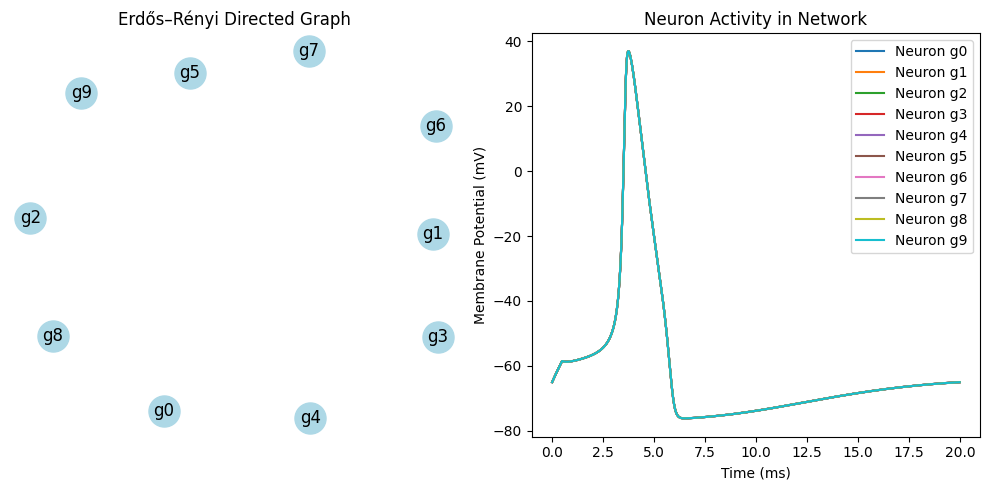

In [23]:
g = generate_erdos_renyi_digraph(10, 0, s='g')

# Parameters
T = 20.0
dt = 0.01
time = np.arange(0, T, dt)

I_inp = np.zeros(len(time))
I_inp[int(0/dt):int(0.5/dt)] = 15.0
I_inp[0] = 0

# Record data
V = {}
nodes = g.nodes()
for node in nodes:
        V[node] = []

Network = g.nodes()
for i in range(len(time)):
    for node in Network:
        neuron = Network[node]['neuron']
        neuron.step(I_inp[i])
        V[node].append(neuron.V)


# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20, ax=axes[0])
axes[0].set_title("Erdős–Rényi Directed Graph")
for node, voltages in V.items():
    axes[1].plot(time, voltages, label=f'Neuron {node}')
axes[1].legend()
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("Membrane Potential (mV)")
axes[1].set_title("Neuron Activity in Network")
plt.tight_layout()
plt.show()


### Single Layer

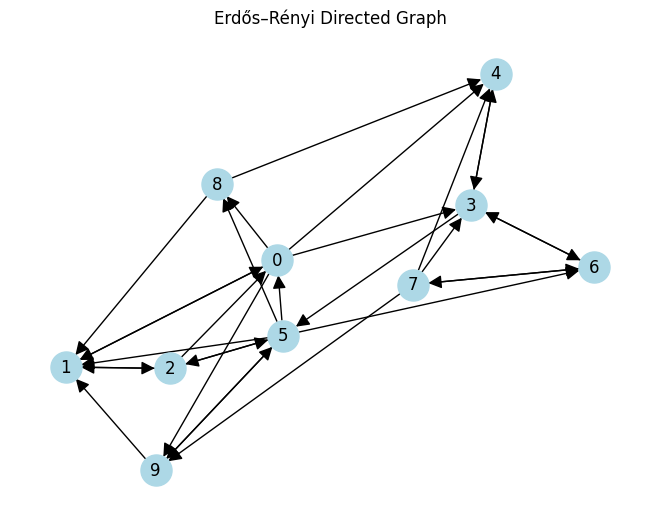

In [24]:
# Parameters
n = 10
p = 0.3

# Generate the graph
digraph = generate_erdos_renyi_digraph(n, p)

# Draw the graph
pos = nx.spring_layout(digraph)
nx.draw(digraph, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()

## Layered Network

### Two layers

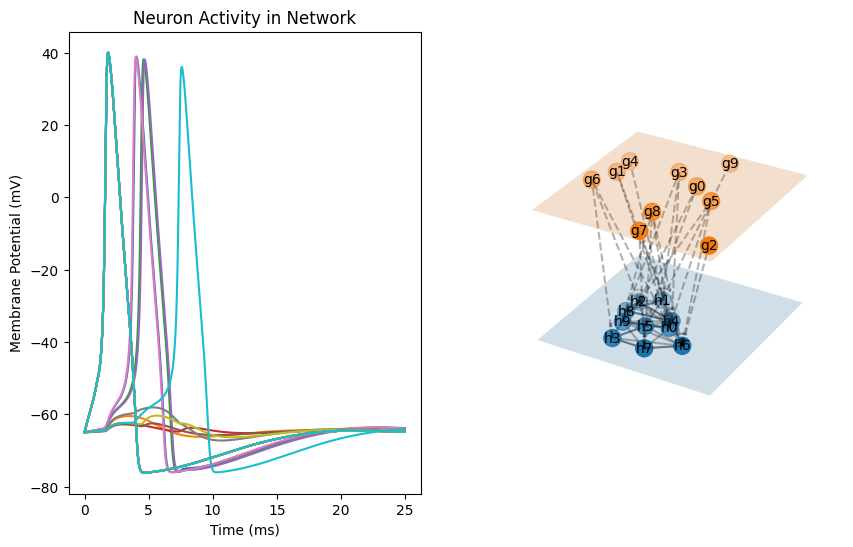

4.994


In [34]:
n = 10
p = 0.5
prob_inter = 0.2
time = 25
step = 0.01

Network = LayeredNetworkGraph([(n, 0, 'g'), (n, p, 'h')], time, step, inter_prob=prob_inter, verbose=True)
t = Network.run()

print(t)

##### Analysis

In [26]:
# Parameters
n = 10
p = 0.5
dt = 0.01
ps = np.arange(0, 1 + dt, dt)
time = 25
step = 0.01


# Simulation
N_sim = 20
peak_times = []
for pr in ps:
    Network = LayeredNetworkGraph([(n, 0, 'g'), (n, p, 'h')], time, step, inter_prob=pr, verbose=False)
    t = Network.run()

    peak_times.append(t)

In [27]:
import numpy as np
from multiprocessing import Pool

# Assuming LayeredNetworkGraph is defined elsewhere
# Define your parameters
n = 20
p = 0.5
dt = 0.01
ps = np.arange(0, 1 + dt, dt)
time = 25
step = 0.01
N_sim = 20

# Function to run a single simulation
def run_simulation(pr):
    # Initialize the network
    Network = LayeredNetworkGraph([(n, 0, 'g'), (n, p, 'h')], time, step, inter_prob=pr, verbose=False)
    # Run the simulation and return the result
    return Network.run()

# Parallel execution
if __name__ == "__main__":
    # Create a pool of worker processes
    with Pool(processes=4) as pool:
        # Run the simulations in parallel for each probability in ps
        peak_times = pool.map(run_simulation, ps)

    # print("Peak times:", peak_times)


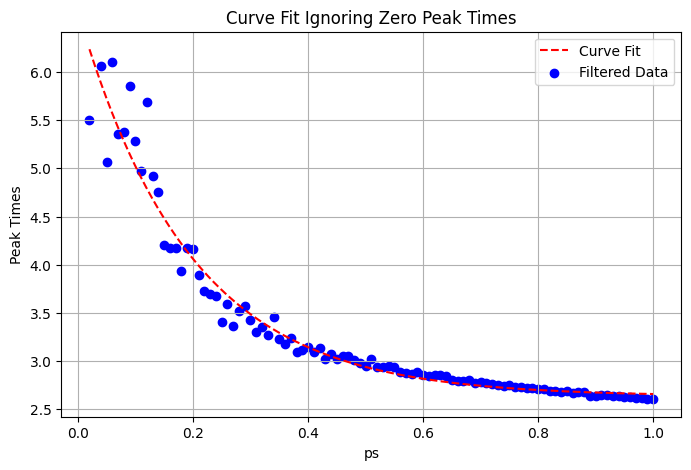

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example: A function to fit (e.g., exponential decay)
def fit_function(x, a, b, c):
    return a * np.exp(-b * x) + c

# Filter out peak_times == 0
valid_indices = np.array(peak_times) != 0  # Create a mask for non-zero values
filtered_ps = ps[valid_indices]
filtered_peak_times = np.array(peak_times)[valid_indices]

# Perform curve fitting
popt, pcov = curve_fit(fit_function, filtered_ps, filtered_peak_times)

# Generate data for plotting the fit
fit_x = np.linspace(min(filtered_ps), max(filtered_ps), 500)
fit_y = fit_function(fit_x, *popt)

# Plot the results
plt.figure(figsize=(8, 5))
plt.scatter(filtered_ps, filtered_peak_times, label="Filtered Data", color="blue")
plt.plot(fit_x, fit_y, label="Curve Fit", color="red", linestyle="--")
plt.xlabel("ps")
plt.ylabel("Peak Times")
plt.legend()
plt.title("Curve Fit Ignoring Zero Peak Times")
plt.grid()
plt.show()


In [29]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from modules.hh_model import HodgkinHuxleyNeuron
from concept.hh_model import HodgkinHuxleyNeuron as NoJitHodgkinHuxleyNeuron

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Numba
from numba import njit, float64, typed, int32, typeof
from numba.experimental import jitclass
from numba.core import types
from numba.typed import Dict as NumbaDict, List as NumbaList
from typing import List, Dict
import time as tm

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [30]:
n = HodgkinHuxleyNeuron(0.01)
kv_ty = (types.unicode_type, typeof(n))
pd_ty = (types.unicode_type, types.ListType(types.unicode_type))

spec = [
    ('name', types.unicode_type),
    ('step', float64),
    ('n', int32),
    ('p', float64),
    ('nodes', types.DictType(*kv_ty)),
    ('preds', types.DictType(*pd_ty))
]


@jitclass(spec)
class Layer:
    def __init__(self, name, step, n, p):
        self.name = name
        self.step = step
        self.n = n
        self.p = p
        self.nodes = typed.Dict.empty(*kv_ty)
        self.preds = typed.Dict.empty(*pd_ty)

        self.get_nodes()

    def get_nodes(self):
        for i in range(self.n):
            key = str(self.name) + str(i)
            self.nodes[key] = HodgkinHuxleyNeuron(self.step)


    def get_preds(self):
        for i in range(self.n):
            for j in range(self.n):
                pass


L = Layer('g', 0.01, 3, 0.1)
print(L.nodes)


{g0: <numba.experimental.jitclass.boxing.HodgkinHuxleyNeuron object at 0x70e349c91ae0>, g1: <numba.experimental.jitclass.boxing.HodgkinHuxleyNeuron object at 0x70e349d3f6d0>, g2: <numba.experimental.jitclass.boxing.HodgkinHuxleyNeuron object at 0x70e349c91ae0>}
